In [162]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [152]:
class Newsvendor:
    def __init__(self, demand, SD, sell, cost, salvage):
        self.mu = demand
        self.SD = SD
        self.sellprice = sell
        self.cost = cost
        self.salvageprice = salvage
        self._Cu = self.sellprice - self.cost
        self._Co = self.cost - self.salvageprice
        self._criticalRatio = self._Cu / (self._Cu + self._Co)
        
        
    def clearParameters(self):
        self.mu = 0
        self.SD = 0
        self.sellprice = 0
        self.cost = 0
        self.salvage = 0
        self._Cu = 0
        self._Co = 0
        self._criticalRatio = 0
        
    def setParameters(self, demand, SD, sell, cost, salvage):
        self.mu = demand
        self.SD = SD
        self.sellprice = sell
        self.cost = cost
        self.salvageprice = salvage
        self._Cu = self.sellprice - self.cost
        self._Co = self.cost - self.salvageprice
        self._criticalRatio = self._Cu / (self._Cu + self._Co)
        
    def showParameters(self):
        summary = {'Demand': self.mu,
                  'Standard Deviation': self.SD,
                  'Selling Price': self.sellprice,
                  'Cost': self.cost,
                  'Salvage Value': self.salvageprice}
        
        return summary
        
    def optimalQuantity(self):
        optimal_production = round(norm(self.mu, self.SD).ppf(self._criticalRatio))
        safety_stock = optimal_production - self.mu
        quantity_summary = {'optimal quantity': optimal_production, 'average demand': self.mu, 'safety stock': safety_stock}
        
        return quantity_summary
    
    def optimalSummary(self, simulations=1, trials=1000000):
        production = round(norm(self.mu, self.SD).ppf(self._criticalRatio))
        demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))

        # salvage quantities
        salvage_quantity = production - demand
        salvage_quantity = np.where(salvage_quantity<0, 0, salvage_quantity)
        salvage_revenue = salvage_quantity * self.salvageprice

        # expected lost sales
        lost_sales_quantity = demand - production
        lost_sales_quantity = np.where(lost_sales_quantity<0, 0, lost_sales_quantity)

        # items sold
        units_sold = np.minimum(demand, production)

        # item rev
        unit_revenue = units_sold * self.sellprice

        # total rev
        TR = unit_revenue + salvage_revenue

        # COGS
        COGS = production * self.cost

        # gross profit
        GP = TR - COGS
        
        dict_summ = {'Order Quantity': production,
                    'Expected Lost Sales Quantity': np.round(np.mean(lost_sales_quantity), 0),
                    'Expected Lost Sales Revenue': round(np.mean(lost_sales_quantity) * self.sellprice, 2),
                    'Expected Sales Quantity': round(np.mean(units_sold), 0),
                    'Expected Leftover Quantity': round(np.mean(salvage_quantity), 0),
                    'Fill Rate': round(np.mean(units_sold) / self.mu, 4),
                    'Stockout probability': round(norm.sf((production-self.mu)/self.SD), 4)}
        
        
        
        return dict_summ
    
    def targetInStockProba(self, instock_pct, simulations=1, trials=1000000):
        production = round(norm(self.mu, self.SD).ppf(instock_pct))
        demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))

        # salvage quantities
        salvage_quantity = production - demand
        salvage_quantity = np.where(salvage_quantity<0, 0, salvage_quantity)
        salvage_revenue = salvage_quantity * self.salvageprice

        # expected lost sales
        lost_sales_quantity = demand - production
        lost_sales_quantity = np.where(lost_sales_quantity<0, 0, lost_sales_quantity)
        avg_lost_sales = round(np.mean(lost_sales_quantity), 0) #for dict_summ

        # items sold
        units_sold = np.minimum(demand, production)

        # item rev
        unit_revenue = units_sold * self.sellprice

        # total rev
        TR = unit_revenue + salvage_revenue

        # COGS
        COGS = production * self.cost

        # gross profit
        GP = TR - COGS
        
        dict_summ = {'Chosen In-Stock Probability': instock_pct,
                    'Order Quantity': production,
                    'Expected Lost Sales Quantity': avg_lost_sales,
                    'Expected Lost Sales Revenue': avg_lost_sales * self.sellprice,
                    'Expected Sales Quantity': round(np.mean(units_sold), 0),
                    'Expected Leftover Quantity': round(np.mean(salvage_quantity), 0),
                    'Fill Rate': round(np.mean(units_sold) / self.mu, 4),
                    'Stockout probability': round(norm.sf((production-self.mu)/self.SD), 4)}
        
        return dict_summ
    
    def quantityPerformanceSummary(self, quantity, simulations=1, trials=1000000):
        production = quantity
        demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))

        # salvage quantities
        salvage_quantity = production - demand
        salvage_quantity = np.where(salvage_quantity<0, 0, salvage_quantity)
        salvage_revenue = salvage_quantity * self.salvageprice

        # expected lost sales
        lost_sales_quantity = demand - production
        lost_sales_quantity = np.where(lost_sales_quantity<0, 0, lost_sales_quantity)
        avg_lost_sales = round(np.mean(lost_sales_quantity), 0) #for dict_summ

        # items sold
        units_sold = np.minimum(demand, production)

        # item rev
        unit_revenue = units_sold * self.sellprice

        # total rev
        TR = unit_revenue + salvage_revenue

        # COGS
        COGS = production * self.cost

        # gross profit
        GP = TR - COGS
        
        dict_summ = {'Chosen Order Quantity': production,
                    'Expected Lost Sales Quantity': avg_lost_sales,
                    'Expected Lost Sales Revenue': avg_lost_sales * self.sellprice,
                    'Expected Sales Quantity': round(np.mean(units_sold), 0),
                    'Expected Leftover Quantity': round(np.mean(salvage_quantity), 0),
                    'Fill Rate': round(np.mean(units_sold) / self.mu, 4),
                    'Stockout probability': round(norm.sf((production-self.mu)/self.SD), 4)}
                
        return dict_summ
    
    def fillRateSummary(self, upper_SD_bound=3, steps=10, showGraph=False, simulations=1, trials=1000000):
        
        # set bounds for testing production quantities
        upper_production_bound = self.mu + (upper_SD_bound * self.SD) # upper limit set by number of SD away from mean
        unit_production_range = range(0, upper_production_bound, steps)
        
        # create arrays to store fill rates
        fill_rate_array = np.zeros(len(unit_production_range))
        
        for i, j in enumerate(unit_production_range):
            production = j
            demand = np.round(np.random.normal(self.mu, self.SD, (simulations, trials)))
            
            # average of units_sold array is numerator component of fill rate
            units_sold = np.minimum(demand, production)
            
            fill_rate_array[i] = round(np.mean(units_sold) / self.mu, 4)
        
        # create dataframe
        df_fill_rate = pd.DataFrame({
            'Quantity': np.array(unit_production_range),
            'Fill Rate': fill_rate_array
        }).set_index('Quantity')
        
        
        if showGraph==True:

            fig, ax = plt.subplots(figsize=(12,8))
            ax.set_title('Corresponding Fill Rate from Each Production Quantity')
            ax.set_xlabel('Quantity')
            ax.set_ylabel('Fill Rate')
            ax.plot(df_fill_rate.index, df_fill_rate['Fill Rate'])
            
            plt.show()
            
        else:
            None
        
        return df_fill_rate

In [153]:
t1 = Newsvendor(192, 58, 131, 100, 81)

In [154]:
t1.showParameters()

{'Demand': 192,
 'Standard Deviation': 58,
 'Selling Price': 131,
 'Cost': 100,
 'Salvage Value': 81}

In [155]:
t1.optimalSummary()

{'Order Quantity': 210,
 'Expected Lost Sales Quantity': 15.0,
 'Expected Lost Sales Revenue': 1993.32,
 'Expected Sales Quantity': 177.0,
 'Expected Leftover Quantity': 33.0,
 'Fill Rate': 0.9204,
 'Stockout probability': 0.3781}

In [156]:
t1.targetInStockProba(0.99)

{'Chosen In-Stock Probability': 0.99,
 'Order Quantity': 327,
 'Expected Lost Sales Quantity': 0.0,
 'Expected Lost Sales Revenue': 0.0,
 'Expected Sales Quantity': 192.0,
 'Expected Leftover Quantity': 135.0,
 'Fill Rate': 0.9986,
 'Stockout probability': 0.01}

In [157]:
t1.quantityPerformanceSummary(320)

{'Chosen Order Quantity': 320,
 'Expected Lost Sales Quantity': 0.0,
 'Expected Lost Sales Revenue': 0.0,
 'Expected Sales Quantity': 192.0,
 'Expected Leftover Quantity': 128.0,
 'Fill Rate': 0.9985,
 'Stockout probability': 0.0137}

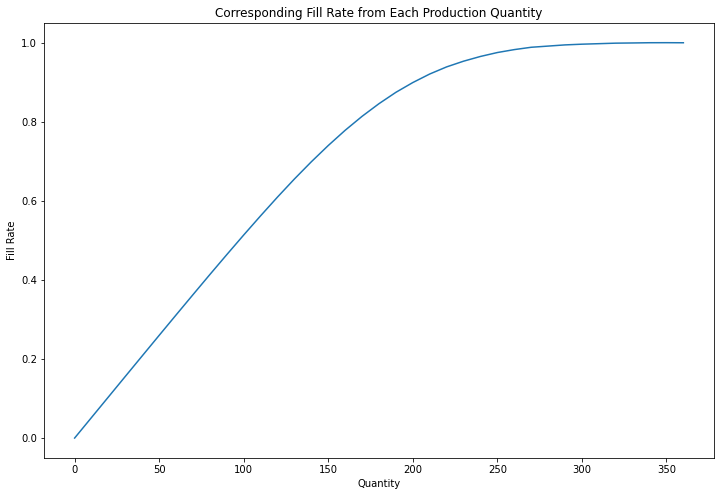

In [159]:
df_fill_rate = t1.fillRateSummary(showGraph=True)